# Overview
We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.
The competition is evaluated using Accuracy as a metric.

We will build an unsupervised model and then compare it's performance with a supervised model.

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed

# Input data files are available in the read-only "./data/" directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Output fils will be in ./output directory

./data/BBC News Train.csv
./data/.DS_Store
./data/Icon
./data/BBC News Test.csv
./data/BBC News Sample Solution.csv


In [3]:
pip install "tmtoolkit[recommended]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 45.8 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19545 sha256=ef5c095f51e7e627a765313924801bcc39fe3eae177923e351f375e5ce43c2b0
  Stored in directory: /root/.cache/pip/wheels/e6/c5/26/0d27e07d567b3b4e63a618efff19a2cdbab636ac1295d20206
Successfully built globre
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install seaborn


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pip-system-certs


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!python3 -m tmtoolkit setup en

# Note: you may need to restart the kernel to use updated packages.

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens, doc_tokens

from string import punctuation

# 1- Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

**1- Let's load the train and test data and see visual inspection**

In [7]:
#Load the data
traindf = pd.read_csv("./data/BBC News Train.csv")
testdf = pd.read_csv("./data/BBC News Test.csv")

#Perform an inspection on train data
# print(traindf.describe())
print(traindf.info())
print("\n\nhead")
print(traindf.head())
print("\n\ntail")
print(traindf.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


head
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business


tail
      ArticleId                                               Text  \
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart s

We can see there are total 1490 records and 3 columns. All columns have non-null values but there could be non-standard nulls.

**2- Let's see if we have non-standard (string-typed) nulls/none values**

In [6]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

for c in traindf.columns:
    string_null = np.array([x in a[2:] for x in traindf[c]])
    print(c, traindf[c].isnull().sum(), string_null.sum())

ArticleId 0 0
Text 0 0
Category 0 0


We are now confirmed that there are not any nulls in the train data.

**3- Let's repeat above steps to check our validation data as well.**

In [7]:
#Perform an inspection on validation data
print(testdf.info())
print("\n\nhead")
print(testdf.head())
print("\n\ntail")
print(testdf.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


head
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


tail
     ArticleId                                               Text
730       1923  eu to probe alitalia  state aid  the european ...
731        373  u2 to play at grammy awards show irish rock ba...
732       1704  sport betting rules in spotlight a group of mp...
733        206  alfa r

We can see there are total 1490 records and 2 columns. All columns have non-null values but there could be non-standard nulls.
Test data does not have category.

In [8]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

for c in testdf.columns:
    string_null = np.array([x in a[2:] for x in testdf[c]])
    print(c, testdf[c].isnull().sum(), string_null.sum())

ArticleId 0 0
Text 0 0


We are now confirmed that there are not any nulls in the test data as well.

**4- Let's remove punctuations, stop words, numbers and lemmetize the words**

We will use tmtoolkit package for this. tmtoolkit is a set of tools for text mining and topic modeling with Python.
This step will take some time.


In [9]:
def build_corpus(texts, lang="en"):
    """Corpus builder which returns a Corpus object processed on texts as language
    specified by lang (defaults to "en"):

    Performs all of the following pre-processing functions:

     - Lemmatize the tokens
     - Convert tokens to lowercase
     - Remove punctuation
     - Remove numbers
     - Remove tokens shorter than 2 characters
    """
    # Here, we just use the index of the text as the label for the corpus item
    corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)

    # Lemmatize the tokens
    lemmatize(corpus, inplace=True)

    # Convert tokens to lowercase
    to_lowercase(corpus, inplace=True)

    # Remove punctuation
    remove_chars(corpus, chars=punctuation, inplace=True)

    # Remove tokens shorter than 2 characters
    filter_clean_tokens(corpus, remove_shorter_than=2, remove_numbers=True, inplace=True)

    return corpus

tokenized_text = build_corpus(traindf['Text'])

Let's see the updated traindf after adding new columns tokens. This step will take some time.

In [10]:
traindf['tokens'] = [doc_tokens(tokenized_text)[i] for i in range(len(traindf))]
print(traindf.info())
print("\n\nhead")
print(traindf.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
 3   tokens     1490 non-null   object
dtypes: int64(1), object(3)
memory usage: 46.7+ KB
None


head
   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

                                              tokens  
0  [worldcom, ex, boss, launch, defence, lawyer, ...  
1  [german, business, co

Let's see the tokens for first article.

In [12]:
traindf['tokens'][0]

['worldcom',
 'ex',
 'boss',
 'launch',
 'defence',
 'lawyer',
 'defend',
 'worldcom',
 'chief',
 'bernie',
 'ebber',
 'battery',
 'fraud',
 'charge',
 'call',
 'company',
 'whistleblower',
 'witness',
 'cynthia',
 'cooper',
 'worldcom',
 'ex',
 'head',
 'internal',
 'accounting',
 'alert',
 'director',
 'irregular',
 'accounting',
 'practice',
 'telecoms',
 'giant',
 'warning',
 'lead',
 'collapse',
 'firm',
 'follow',
 'discovery',
 '11bn',
 '57bn',
 'accounting',
 'fraud',
 'mr',
 'ebber',
 'plead',
 'guilty',
 'charge',
 'fraud',
 'conspiracy',
 'prosecution',
 'lawyer',
 'argue',
 'mr',
 'ebber',
 'orchestrate',
 'series',
 'accounting',
 'trick',
 'worldcom',
 'order',
 'employee',
 'hide',
 'expense',
 'inflate',
 'revenue',
 'meet',
 'wall',
 'street',
 'earning',
 'estimate',
 'ms',
 'cooper',
 'run',
 'consulting',
 'business',
 'tell',
 'jury',
 'new',
 'york',
 'wednesday',
 'external',
 'auditor',
 'arthur',
 'andersen',
 'approve',
 'worldcom',
 'accounting',
 'early',
 '

Let's build token corpus for validation data as well. This step will take some time.

In [13]:
tokenized_text = build_corpus(testdf['Text'])
testdf['tokens'] = [doc_tokens(tokenized_text)[i] for i in range(len(testdf))]
print(testdf.info())
print("\n\nhead")
print(testdf.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
 2   tokens     735 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.4+ KB
None


head
   ArticleId                                               Text  \
0       1018  qpr keeper day heads for preston queens park r...   
1       1319  software watching while you work software that...   
2       1138  d arcy injury adds to ireland woe gordon d arc...   
3        459  india s reliance family feud heats up the ongo...   
4       1020  boro suffer morrison injury blow middlesbrough...   

                                              tokens  
0  [qpr, keeper, day, head, preston, queens, park...  
1  [software, watch, work, software, monitor, key...  
2  [arcy, injury, add, ireland, woe, gordon, arcy...  
3  [india, reli

**5- Let's see if our data is balanced. We will check number of articles per category, number of tokens per article.**

<Axes: ylabel='Category'>

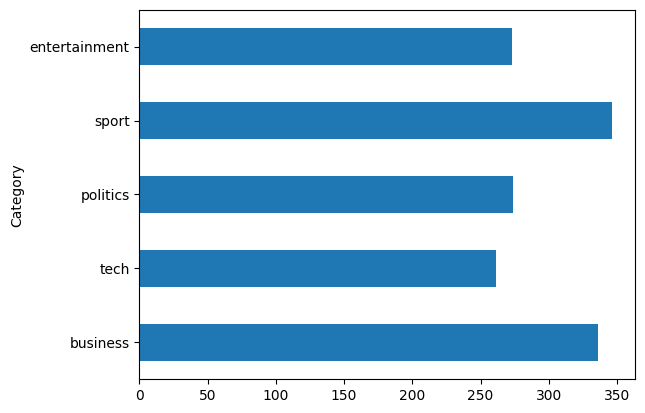

In [14]:
traindf['Category'].value_counts()[traindf['Category'].unique()].plot.barh(stacked=True)

We can see that the categories are balanced with each category having 250 to 350 articles.

([<matplotlib.axis.XTick at 0x7f806be0a620>,
 [Text(0, 0, '0'),
  Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(150, 0, '150'),
  Text(200, 0, '200'),
  Text(250, 0, '250'),
  Text(300, 0, '300'),
  Text(350, 0, '350'),
  Text(400, 0, '400'),
  Text(450, 0, '450'),
  Text(500, 0, '500'),
  Text(550, 0, '550'),
  Text(600, 0, '600'),
  Text(650, 0, '650'),
  Text(700, 0, '700'),
  Text(750, 0, '750'),
  Text(800, 0, '800'),
  Text(850, 0, '850'),
  Text(900, 0, '900'),
  Text(950, 0, '950'),
  Text(1000, 0, '1000'),
  Text(1050, 0, '1050'),
  Text(1100, 0, '1100'),
  Text(1150, 0, '1150'),
  Text(1200, 0, '1200'),
  Text(1250, 0, '1250'),
  Text(1300, 0, '1300'),
  Text(1350, 0, '1350'),
  Text(1400, 0, '1400')])

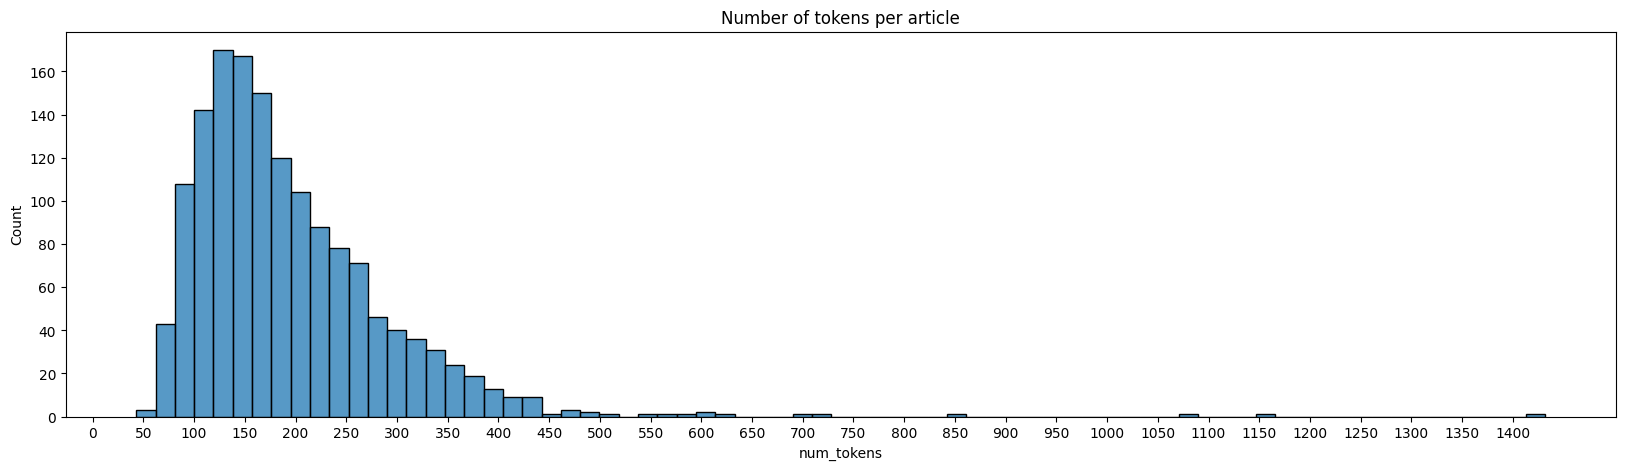

In [15]:
traindf['num_tokens'] = traindf['tokens'].apply(len)

fig, ax = plt.subplots(figsize=(20, 5))
sns.histplot(data = traindf, x = 'num_tokens').set(title = 'Number of tokens per article');
plt.xticks(range(0, max(traindf['num_tokens'])+1, 50))

We can see that most articles have 150 tokens. Each article has atleast 50 tokens with some articles having more than 1000 tokens.

# Feature Extraction using TF-IDF 

We will be using TF-IDF technique for feature extraction and before moving further let's understand what it is and why it is used.
TF-IDF, which stands for Term Frequency-Inverse Document Frequency, is a technique used for feature extraction in natural language processing and text mining. It's employed to quantify the importance of individual terms within a document relative to a collection of documents, typically a corpus. The TF-IDF score for a term in a document combines two key components:

Term Frequency (TF): This measures how often a term appears in a specific document. It reflects the frequency of a term within the document, with higher values for terms that occur more frequently. TF is a local measure that highlights the importance of a term within a single document.The frequency of a term in a document is calculated as: $$TF(i, j) = \frac{\text{Frequency of term i in document j}}{\text{Total word count of document j}}$$

Inverse Document Frequency (IDF): IDF, on the other hand, assesses how unique or rare a term is across the entire corpus. It is calculated by taking the logarithm of the ratio between the total number of documents in the corpus and the number of documents containing the term. High IDF values are assigned to terms that are unique and distinctive across the corpus.
The inverse document frequency of a term over all documents is calculated as: $$IDF(i) = \log_2{\frac{\text{Total number of documents}}{\text{Number of documents with term i}}}$$

By combining TF and IDF, the TF-IDF score assigns higher values to terms that are not only frequent within a document but also relatively rare across the entire corpus. This allows it to capture the significance of terms in a document while also accounting for their uniqueness in the broader context. TF-IDF is widely used in information retrieval, text classification, and text mining tasks to identify important keywords, perform document ranking, and improve text analysis accuracy.

References: https://medium.com/geekculture/text-feature-extraction-2-3-tf-idf-model-c3a8f7a92bc9

**TF-IDF vs Word visualization for train data**

Let's visualize the word vs tfidf score for top 20 words in the train data

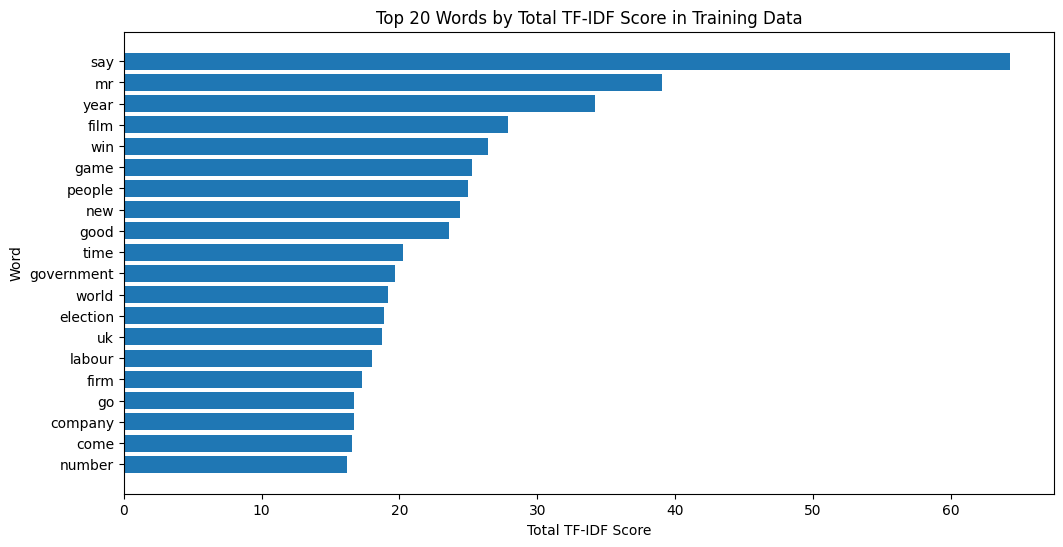

In [19]:
# Feature extraction on training data
train_tfidf_vectorizer = TfidfVectorizer()
train_preprocessed_tokens = traindf['tokens'].apply(lambda tokens: ' '.join(tokens))

train_tfidf_matrix = train_tfidf_vectorizer.fit_transform(train_preprocessed_tokens) #sparse matrix
feature_names = train_tfidf_vectorizer.get_feature_names_out()

# Calculate the sum of TF-IDF scores for each word (absolute TF-IDF score)
total_tfidf_scores = np.asarray(train_tfidf_matrix.todense().sum(axis=0)).ravel()

# Sort the words by their total TF-IDF scores in descending order
sorted_word_indices = np.argsort(total_tfidf_scores)[::-1]
sorted_words = [feature_names[i] for i in sorted_word_indices]

# Select the top 20 words for visualization
top_n = 20
top_words = sorted_words[:top_n]
top_scores = total_tfidf_scores[sorted_word_indices][:top_n]

# Create a bar plot to visualize the top words and their TF-IDF scores
plt.figure(figsize=(12, 6))
plt.barh(top_words, top_scores)
plt.xlabel('Total TF-IDF Score')
plt.ylabel('Word')
plt.title('Top {} Words by Total TF-IDF Score in Training Data'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest scores at the top
plt.show()

In [21]:
# Feature extraction on test data
test_tfidf_vectorizer = TfidfVectorizer()
test_preprocessed_tokens = testdf['tokens'].apply(lambda tokens: ' '.join(tokens))
# We need to ensure that both the training and test data are transformed using the same TF-IDF vectorizer else we will get error.
test_tfidf_matrix = train_tfidf_vectorizer.transform(test_preprocessed_tokens)

# 2- Building and training models.

*1) Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?*

Ans- When training an unsupervised matrix factorization model, it's crucial not to include text data from the test dataset during training to prevent data leakage. Incorporating test data can lead to overfitting, distorting the model's performance. The separation of training and test datasets is essential to evaluate how well the model generalizes to unseen data, ensuring a valid assessment. This practice mimics real-world scenarios where test data is unavailable at deployment. By maintaining this separation, the model's integrity is preserved, and performance evaluation remains unbiased, reflecting its true ability to generalize.

Let's build the Non-Negative Matrix Factorization (NMF) model. NMF is a valuable technique when working with TF-IDF representations of text data because it aligns with the non-negativity and sparsity of the data, aids in topic modeling, reduces dimensionality, and, most importantly, yields interpretable results that help in understanding the underlying structure of the text corpus.

# Let's build our model with L2-loss (frobenius)

In [22]:
nmf_model = NMF(n_components=5, init='nndsvd', random_state=1, beta_loss='frobenius')
nmf_matrix = nmf_model.fit_transform(train_tfidf_matrix)
    
# Display Top 10 Words for Each Topic
feature_names = train_tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


Topic #1: game, win, england, player, say, team, match, cup, ireland, wale
Topic #2: mr, labour, election, blair, party, say, tory, brown, minister, government
Topic #3: mobile, phone, people, technology, music, service, say, user, digital, gadget
Topic #4: film, award, good, star, oscar, actor, win, actress, nomination, director
Topic #5: growth, rate, economy, rise, say, bank, year, market, economic, sale


**Let's measure the performance of our model on the train data using L2-loss**

In [23]:
kmeans = KMeans(n_clusters=5, random_state=1)
train_predictions = normalize(nmf_model.transform(train_tfidf_matrix))  # Normalize topic weights
category_labels_predicted = kmeans.fit_predict(train_predictions)

# Add the predicted category labels to the DataFrame
traindf['Predicted_Category'] = category_labels_predicted
# print(traindf['Predicted_Category'].unique())
# print(traindf['Category'].unique())
print(traindf[['tokens', 'Predicted_Category']])

# Map numeric labels to category names after visual inspection
category_mapping = {
    0: 'business',
    1: 'entertainment',
    2: 'politics',
    3: 'tech',
    4: 'sport'
}

traindf['Predicted_Category'] = traindf['Predicted_Category'].map(category_mapping)
# print(traindf['Predicted_Category'].unique())
# Display the DataFrame with predicted categories
print(traindf[['tokens', 'Predicted_Category']])

train_true_labels = traindf['Category']
train_accuracy = accuracy_score(traindf['Category'], traindf['Predicted_Category'])
train_confusion_matrix = confusion_matrix(traindf['Category'], traindf['Predicted_Category'])
train_classification_report = classification_report(traindf['Category'], traindf['Predicted_Category'])

print(train_classification_report)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                                 tokens  Predicted_Category
0     [worldcom, ex, boss, launch, defence, lawyer, ...                   2
1     [german, business, confidence, slide, german, ...                   0
2     [bbc, poll, indicate, economic, gloom, citizen...                   0
3     [lifestyle, govern, mobile, choice, fast, well...                   3
4     [enron, boss, payout, enron, director, agree, ...                   0
...                                                 ...                 ...
1485  [double, eviction, big, brother, model, capric...                   1
1486  [dj, double, act, revamp, chart, dj, duo, jk, ...                   1
1487  [weak, dollar, hit, reuter, revenue, medium, g...                   0
1488  [apple, ipod, family, expand, market, apple, e...                   3
1489  [santy, worm, make, unwelcome, visit, thousand...                   3

[1490 rows x 2 columns]
                                                 tokens Predict

**We can see that the f1-score for all cateogries on train data is more tha 0.90 so our model is predicting the categories nicely.**

**Let's get the predictions for test data now usng L2-loss.**

In [24]:
kmeans = KMeans(n_clusters=5, random_state=1)
test_predictions = normalize(nmf_model.transform(test_tfidf_matrix))  # Normalize topic weights
category_labels_predicted = kmeans.fit_predict(test_predictions)

# Add the predicted category labels to the DataFrame
testdf['Category'] = category_labels_predicted

# Map numeric labels to category names after visual inspection
category_mapping = {
    0: 'business',
    1: 'tech',
    2: 'sport',
    3: 'entertainment',
    4: 'politics'
}

testdf['Category'] = testdf['Category'].map(category_mapping)
print(testdf[['ArticleId', 'tokens', 'Category']])

data = testdf[['ArticleId', 'Category']]
file_path = './data/output/output-l2.csv'
# Write the data to a CSV file with headers
data.to_csv(file_path, index=False)

     ArticleId                                             tokens  \
0         1018  [qpr, keeper, day, head, preston, queens, park...   
1         1319  [software, watch, work, software, monitor, key...   
2         1138  [arcy, injury, add, ireland, woe, gordon, arcy...   
3          459  [india, reliance, family, feud, heat, ongoing,...   
4         1020  [boro, suffer, morrison, injury, blow, middles...   
..         ...                                                ...   
730       1923  [eu, probe, alitalia, state, aid, european, co...   
731        373  [u2, play, grammy, awards, irish, rock, band, ...   
732       1704  [bet, rule, spotlight, group, mp, peer, call, ...   
733        206  [alfa, romeo, gm, engine, fiat, stop, make, cy...   
734        471  [citizenship, event, 18, tout, citizenship, ce...   

          Category  
0            sport  
1             tech  
2            sport  
3         business  
4            sport  
..             ...  
730       business  
731

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**By submitting to kaggle, we got the following result for test data predictions, public score: 0.93197**

# Let's build our model with KL-loss (kullback-leibler)

Let's try to improve by using solver=mu, init=nndsvda, and loss beta_loss: ‘kullback-leibler’

In [25]:
nmf_model = NMF(n_components=5, init='nndsvda', random_state=1, solver='mu', beta_loss='kullback-leibler')
nmf_matrix = nmf_model.fit_transform(train_tfidf_matrix)
    
# Display Top 10 Words for Each Topic
feature_names = train_tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: win, game, england, say, player, match, club, team, cup, injury
Topic #2: mr, say, election, labour, blair, party, government, minister, tory, brown
Topic #3: mobile, phone, say, people, technology, service, user, software, computer, game
Topic #4: film, award, star, good, actor, band, oscar, music, chart, year
Topic #5: say, market, company, growth, bank, economy, firm, year, rise, rate


**Let's measure the performance of our model on the train data using KL-loss**

In [26]:
kmeans = KMeans(n_clusters=5, random_state=1)
train_predictions = normalize(nmf_model.transform(train_tfidf_matrix))  # Normalize topic weights
category_labels_predicted = kmeans.fit_predict(train_predictions)

# Add the predicted category labels to the DataFrame
traindf['Predicted_Category'] = category_labels_predicted
# print(traindf['Predicted_Category'].unique())
# print(traindf['Category'].unique())
print(traindf[['tokens', 'Predicted_Category']])

# Map numeric labels to category names after visual inspection
category_mapping = {
    0: 'business',
    1: 'sport',
    2: 'entertainment',
    3: 'tech',
    4: 'politics'
}

traindf['Predicted_Category'] = traindf['Predicted_Category'].map(category_mapping)
# print(traindf['Predicted_Category'].unique())
# Display the DataFrame with predicted categories
print(traindf[['tokens', 'Predicted_Category']])

train_true_labels = traindf['Category']
train_accuracy = accuracy_score(traindf['Category'], traindf['Predicted_Category'])
train_confusion_matrix = confusion_matrix(traindf['Category'], traindf['Predicted_Category'])
train_classification_report = classification_report(traindf['Category'], traindf['Predicted_Category'])

print(train_classification_report)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                                 tokens  Predicted_Category
0     [worldcom, ex, boss, launch, defence, lawyer, ...                   0
1     [german, business, confidence, slide, german, ...                   0
2     [bbc, poll, indicate, economic, gloom, citizen...                   0
3     [lifestyle, govern, mobile, choice, fast, well...                   3
4     [enron, boss, payout, enron, director, agree, ...                   0
...                                                 ...                 ...
1485  [double, eviction, big, brother, model, capric...                   2
1486  [dj, double, act, revamp, chart, dj, duo, jk, ...                   2
1487  [weak, dollar, hit, reuter, revenue, medium, g...                   0
1488  [apple, ipod, family, expand, market, apple, e...                   3
1489  [santy, worm, make, unwelcome, visit, thousand...                   3

[1490 rows x 2 columns]
                                                 tokens Predict

**We can see that the f1-score for all cateogries on train data is more tha 0.91 so our model is preforming better on train data with KL loss than L2 loss.**

**Let's get the predictions for test data now using KL loss.**

In [27]:
kmeans = KMeans(n_clusters=5, random_state=1)
test_predictions = normalize(nmf_model.transform(test_tfidf_matrix))  # Normalize topic weights
category_labels_predicted = kmeans.fit_predict(test_predictions)

# Add the predicted category labels to the DataFrame
testdf['Category'] = category_labels_predicted

# Map numeric labels to category names after visual inspection
category_mapping = {
    0: 'business',
    1: 'politics',
    2: 'tech',
    3: 'sport',
    4: 'entertainment'
}

testdf['Category'] = testdf['Category'].map(category_mapping)
print(testdf[['ArticleId', 'tokens', 'Category']])

data = testdf[['ArticleId', 'Category']]
file_path = './data/output/output-kl.csv'
# Write the data to a CSV file with headers
data.to_csv(file_path, index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


     ArticleId                                             tokens  \
0         1018  [qpr, keeper, day, head, preston, queens, park...   
1         1319  [software, watch, work, software, monitor, key...   
2         1138  [arcy, injury, add, ireland, woe, gordon, arcy...   
3          459  [india, reliance, family, feud, heat, ongoing,...   
4         1020  [boro, suffer, morrison, injury, blow, middles...   
..         ...                                                ...   
730       1923  [eu, probe, alitalia, state, aid, european, co...   
731        373  [u2, play, grammy, awards, irish, rock, band, ...   
732       1704  [bet, rule, spotlight, group, mp, peer, call, ...   
733        206  [alfa, romeo, gm, engine, fiat, stop, make, cy...   
734        471  [citizenship, event, 18, tout, citizenship, ce...   

          Category  
0            sport  
1             tech  
2            sport  
3         business  
4            sport  
..             ...  
730       business  
731

**By submitting to kaggle, we got the following result for test data predictions, public score: 0.95918**

# Performance summary of Unsupervised model:
1. NMF - l2-loss - kaggle score - 0.93197 
2. NMF - kl-loss - kaggle score - 0.95918

We can see that kl-loss has performed better.

# Compare with supervised learning 

We will use Multi-Class Logistic Regression is well-suited for multi-class text classification tasks, especially when using TF-IDF features. It handles multiple classes, uses the softmax activation for probability estimation, and leverages cross-entropy loss for training.

**Using 10% training data**

In [36]:
# Select 10% of the rows from train_tfidf_matrix
num_samples = int(0.10 * train_tfidf_matrix.shape[0])
X = train_tfidf_matrix[:num_samples]  # Features
y = traindf['Category'][:num_samples]  # Target labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Multi-Class Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Measure accuracy
train_classification_report = classification_report(y_test, y_pred)

print("Training data performance with 10% data:")
print(train_classification_report)


# Let's use our supervised model to predict category labels for test data now.
X_test = test_tfidf_matrix  # Features

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
results_df = pd.DataFrame({'ArticleId': testdf['ArticleId'], 'Category': y_pred})
file_path = './data/output/output-supervised-10.csv'
# Write the data to a CSV file with headers
results_df.to_csv(file_path, index=False)


Training data performance with 10% data:
               precision    recall  f1-score   support

     business       0.67      1.00      0.80         8
entertainment       0.00      0.00      0.00         6
     politics       1.00      0.60      0.75         5
        sport       0.45      1.00      0.62         5
         tech       1.00      0.67      0.80         6

     accuracy                           0.67        30
    macro avg       0.62      0.65      0.59        30
 weighted avg       0.62      0.67      0.60        30



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**By submitting to kaggle with 10% train data, we got the following result for test data predictions using supervised model, public score: 0.63401**

**Using 20% training data**

In [37]:
# Select 20% of the rows from train_tfidf_matrix
num_samples = int(0.20 * train_tfidf_matrix.shape[0])
X = train_tfidf_matrix[:num_samples]  # Features
y = traindf['Category'][:num_samples]  # Target labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Multi-Class Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Measure accuracy
train_classification_report = classification_report(y_test, y_pred)

print("Training data performance with 20% data:")
print(train_classification_report)


# Let's use our supervised model to predict category labels for test data now.
X_test = test_tfidf_matrix  # Features

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
results_df = pd.DataFrame({'ArticleId': testdf['ArticleId'], 'Category': y_pred})
file_path = './data/output/output-supervised-20.csv'
# Write the data to a CSV file with headers
results_df.to_csv(file_path, index=False)


Training data performance with 20% data:
               precision    recall  f1-score   support

     business       0.82      0.93      0.87        15
entertainment       1.00      0.50      0.67        10
     politics       1.00      0.67      0.80        12
        sport       0.57      1.00      0.73        12
         tech       1.00      0.82      0.90        11

     accuracy                           0.80        60
    macro avg       0.88      0.78      0.79        60
 weighted avg       0.87      0.80      0.80        60



**By submitting to kaggle with 20% train data, we got the following result for test data predictions using supervised model, public score: 0.81496**

**Using 50% training data**

In [38]:
# Select 50% of the rows from train_tfidf_matrix
num_samples = int(0.50 * train_tfidf_matrix.shape[0])
X = train_tfidf_matrix[:num_samples]  # Features
y = traindf['Category'][:num_samples]  # Target labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Multi-Class Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Measure accuracy
train_classification_report = classification_report(y_test, y_pred)

print("Training data performance with 50% data:")
print(train_classification_report)


# Let's use our supervised model to predict category labels for test data now.
X_test = test_tfidf_matrix  # Features

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
results_df = pd.DataFrame({'ArticleId': testdf['ArticleId'], 'Category': y_pred})
file_path = './data/output/output-supervised-50.csv'
# Write the data to a CSV file with headers
results_df.to_csv(file_path, index=False)


Training data performance with 50% data:
               precision    recall  f1-score   support

     business       0.90      1.00      0.95        38
entertainment       0.95      0.84      0.89        25
     politics       1.00      0.85      0.92        26
        sport       0.79      1.00      0.89        27
         tech       0.97      0.85      0.90        33

     accuracy                           0.91       149
    macro avg       0.92      0.91      0.91       149
 weighted avg       0.92      0.91      0.91       149



**By submitting to kaggle with 50% train data, we got the following result for test data predictions using supervised model, public score: 0.96054**

**Using 100% training data**

In [32]:
# Split the data into training and testing sets
X = train_tfidf_matrix  # Features
y = traindf['Category']  # Target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Multi-Class Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Measure accuracy
train_classification_report = classification_report(y_test, y_pred)

print("Training data performance with 100% data:")
print(train_classification_report)


# Let's use our supervised model to predict category labels for test data now.
X_test = test_tfidf_matrix  # Features

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
results_df = pd.DataFrame({'ArticleId': testdf['ArticleId'], 'Category': y_pred})
file_path = './data/output/output-supervised-100.csv'
# Write the data to a CSV file with headers
results_df.to_csv(file_path, index=False)


Training data performance with 100% data:
               precision    recall  f1-score   support

     business       0.95      0.97      0.96        75
entertainment       0.96      1.00      0.98        46
     politics       0.96      0.93      0.95        56
        sport       0.97      1.00      0.98        63
         tech       0.98      0.91      0.95        58

     accuracy                           0.96       298
    macro avg       0.96      0.96      0.96       298
 weighted avg       0.96      0.96      0.96       298



**By submitting to kaggle, we got the following result for test data predictions using supervised model, public score: 0.98095**

# Summary- Accuracy vs Training data percentage for Supervised Model

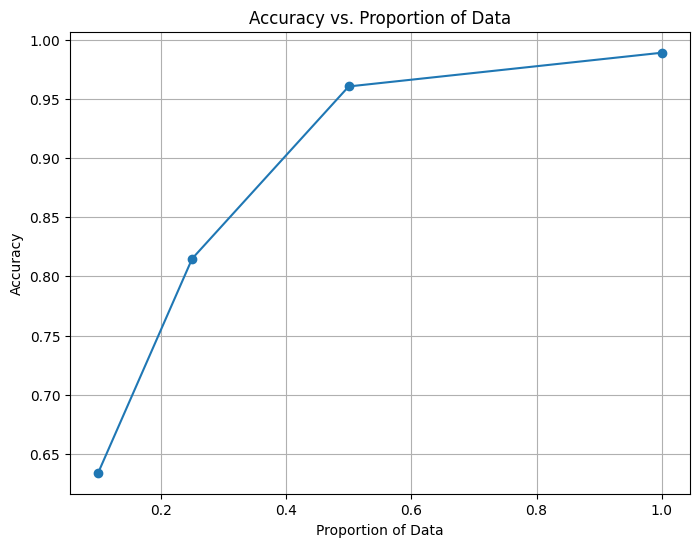

In [42]:
proportion = [0.1, 0.25, 0.5, 1]
accuracy = [0.63401, 0.81496, 0.96054, 0.98905]

plt.figure(figsize=(8, 6))
plt.plot(proportion, accuracy, marker='o', linestyle='-')
plt.title('Accuracy vs. Proportion of Data')
plt.xlabel('Proportion of Data')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

We can see from the abive graph that with 50% training data we were able to achieve high accuracy.

**Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?**

Ans- The comparison between supervised and unsupervised learning approaches, with varying proportions of training data, reveals key insights. The supervised model outperforms the unsupervised model in terms of data efficiency, achieving similar accuracy with only 50% of the training data. This suggests that supervised learning can make more effective use of labeled data, providing a compelling advantage when labeled data is available. Moreover, it demonstrates stronger generalization capabilities and potentially mitigates overfitting due to the regularization effect of labeled data. This observation underscores the label efficiency of supervised learning, making it an appealing choice for scenarios where labeled data is valuable and generalization to unseen data is critical.

# Github Link

https://github.com/arunattri26/MSDS/blob/main/DTSA_5510_Unsupervised_Learning/HW4/BBC/BBCNewsClassification.ipynb

# References

* https://medium.com/geekculture/text-feature-extraction-2-3-tf-idf-model-c3a8f7a92bc9
* https://tmtoolkit.readthedocs.io/en/latest/index.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html